In [1]:
from __future__ import division
import sys, os
tag = 0
decay = "emu"

import matplotlib as mpl
#mpl.use('Agg') #use for python script mode
import matplotlib.pyplot as plt
#plt.ioff()

In [2]:
 #get kerberos token for eos
import getpass
os.system("echo %s | kinit gandreas@CERN.CH" %getpass.getpass()) 

········


0

In [3]:
import numexpr
import os
import root_numpy
import ROOT
import cuts
from getdata.getdata import getData
import pandas as pd
from rep import utils
from sklearn.ensemble import GradientBoostingClassifier
from rep.report.metrics import RocAuc, OptimalSignificance
from tools.PunziFOM import OptimalPunziFOM
from rep.metaml import GridOptimalSearchCV, FoldingScorer, ClassificationFoldingScorer, RandomParameterOptimizer, SubgridParameterOptimizer
from rep.estimators import SklearnClassifier, TMVAClassifier, XGBoostRegressor, TheanetsClassifier, XGBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from rep.metaml import RegressionParameterOptimizer, RandomParameterOptimizer, FoldingClassifier
from sklearn.gaussian_process import GaussianProcess
from rep.report.metrics import OptimalMetric, ams
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn.utils import check_array, check_consistent_length
from sklearn.utils.multiclass import type_of_target
from scipy.stats import randint, uniform
import random
import re
from tools.findcuts import findcuts2
from vars_db import vars_db
default_stdout = sys.stdout #I need this to redirect the stdout back on screen at the end

Welcome to JupyROOT 6.08/02


/cvmfs/lhcb.cern.ch/lib/lcg/releases/LCG_87/ROOT/6.08.02/x86_64-slc6-gcc49-opt/lib/ROOT.py:417: UserWarning: "from ROOT import *" is not supported under IPython
  warnings.warn( '"from ROOT import *" is not supported under IPython' )
/home/guido/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
branches = []
for branch in vars_db:
    if (vars_db[branch]['considered_for_MVA']):
        branches.append(branch)
        
additional_branches = ['L0_FD_ORIVX', 'Lb_TrackIsoBDTInfoL2_TRKISOBDTFIRSTVALUE']

In [5]:
MC_tree = ROOT.TChain('Lb2LemuTuple/DecayTree')
MC_tree.Add(os.getenv("GUIDOANAEOSLOC")+"tuples/S28/MC/Lb_Lemu_MC_2016_M*.root")

data_tree = ROOT.TChain('Lb2LemuTuple/DecayTree')
#temporary fix:
from glob import glob
for file in glob(os.getenv("LBMICKJOBLOC")+"209/[1-3][0-9][0-9]/DVNtuple.root"):
    data_tree.AddFile(file)
for file in glob(os.getenv("LBMICKJOBLOC")+"210/[1-3][0-9][0-9]/DVNtuple.root"):
    data_tree.AddFile(file)



In [6]:
from tools.convert_data import convert_data

import imp
import sys
imp.reload (sys.modules['tools.convert_data'])


signal_training_cut = cuts.Lb_Lemu_matching+cuts.Lb_Lemu_trigger_run1_full

#print signal_training_cut.GetTitle()
#the test sets are just dummy here. test_frac is indeed 0
train_data, train_labels, test_data, test_labels = convert_data (MC_tree,
                                                                 (cuts.Lb_Lemu_HOP_FD_cut+cuts.Lb_Lemu_matching+cuts.Lb_Lemu_trigger_run2_full_for_MVA_training).GetTitle(),
                                                                 data_tree,
                                                                 (cuts.Lb_Lemu_HOP_FD_cut+cuts.Lb_Lemu_right_sideband+cuts.Lb_Lemu_trigger_run2_full_for_MVA_training).GetTitle(),
                                                                 branches+additional_branches,
                                                                 test_frac = 0)
train_data_DD, train_labels_DD, test_data, test_labels = convert_data (MC_tree,
                                                                 (cuts.Lb_Lemu_HOP_FD_cut+cuts.Lb_Lemu_matching+cuts.Lb_Lemu_trigger_run2_full_for_MVA_training+cuts.DD).GetTitle(),
                                                                 data_tree,
                                                                 (cuts.Lb_Lemu_HOP_FD_cut+cuts.Lb_Lemu_right_sideband+cuts.Lb_Lemu_trigger_run2_full_for_MVA_training+cuts.DD).GetTitle(),
                                                                 branches+additional_branches,
                                                                 test_frac = 0)
train_data_LL, train_labels_LL, test_data, test_labels = convert_data (MC_tree,
                                                                 (cuts.Lb_Lemu_HOP_FD_cut+cuts.Lb_Lemu_matching+cuts.Lb_Lemu_trigger_run2_full_for_MVA_training+cuts.LL).GetTitle(),
                                                                 data_tree,
                                                                 (cuts.Lb_Lemu_HOP_FD_cut+cuts.Lb_Lemu_right_sideband+cuts.Lb_Lemu_trigger_run2_full_for_MVA_training+cuts.LL).GetTitle(),
                                                                 branches+additional_branches,
                                                                 test_frac = 0)

In [7]:
#train_data.shape
#train_data_DD.shape[0]+train_data_LL.shape[0]

In [8]:
#let's also prepare signal and background in separate dataframes for convenience
train_data_with_labels = pd.DataFrame(np.hstack((train_data, train_labels.reshape(train_labels.shape[0], -1))),
                  columns=branches+additional_branches+['labels'])
train_data_DD_with_labels = pd.DataFrame(np.hstack((train_data_DD, train_labels_DD.reshape(train_labels_DD.shape[0], -1))),
                  columns=branches+additional_branches+['labels'])
train_data_LL_with_labels = pd.DataFrame(np.hstack((train_data_LL, train_labels_LL.reshape(train_labels_LL.shape[0], -1))),
                  columns=branches+additional_branches+['labels'])

train_data_signal_with_labels = train_data_with_labels.loc[train_data_with_labels['labels']>0.5]
train_data_background_with_labels = train_data_with_labels.loc[train_data_with_labels['labels']<0.5]
train_data_DD_signal_with_labels = train_data_DD_with_labels.loc[train_data_DD_with_labels['labels']>0.5]
train_data_DD_background_with_labels = train_data_DD_with_labels.loc[train_data_DD_with_labels['labels']<0.5]
train_data_LL_signal_with_labels = train_data_LL_with_labels.loc[train_data_LL_with_labels['labels']>0.5]
train_data_LL_background_with_labels = train_data_LL_with_labels.loc[train_data_LL_with_labels['labels']<0.5]

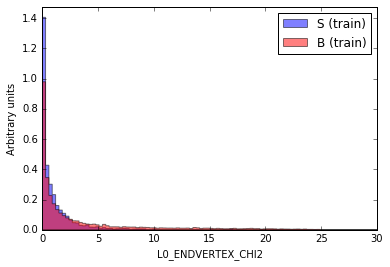

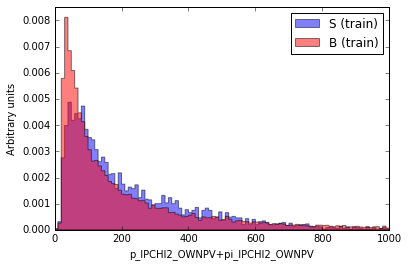

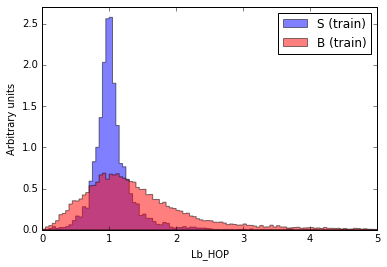

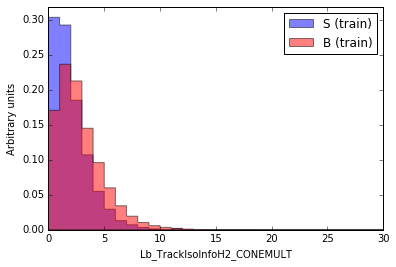

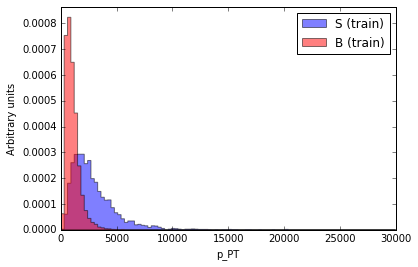

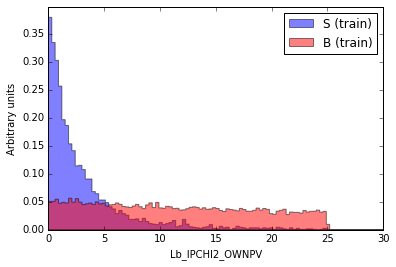

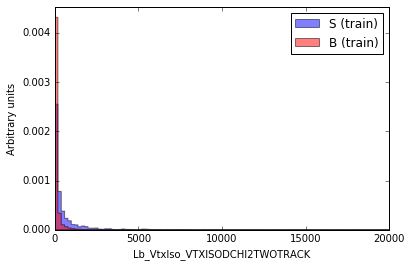

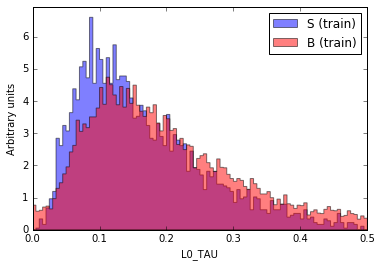

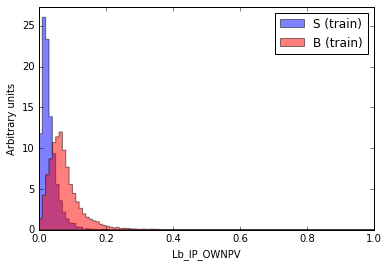

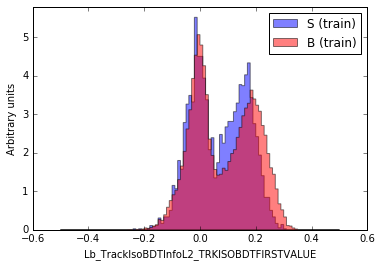

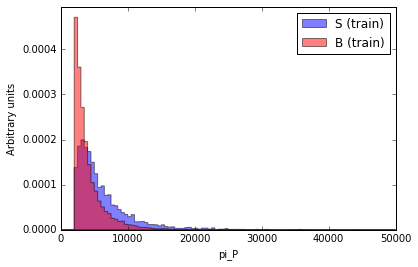

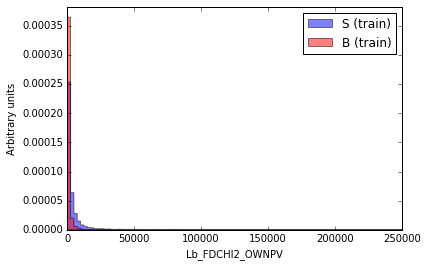

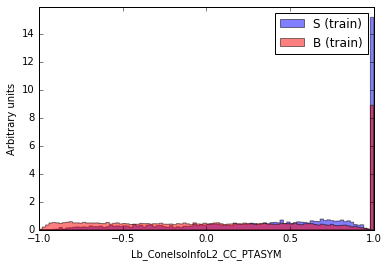

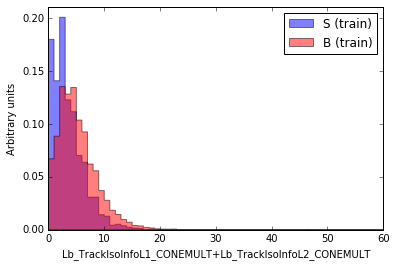

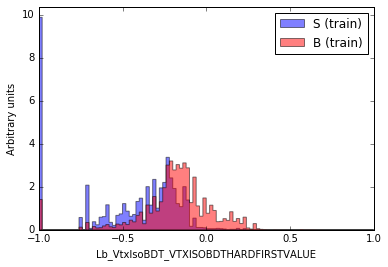

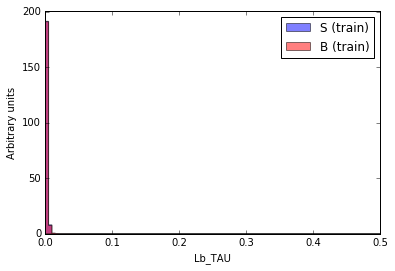

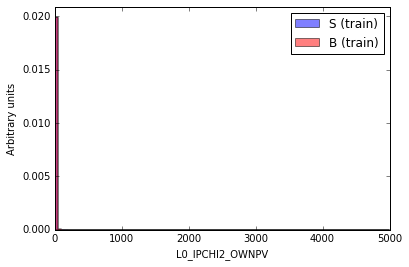

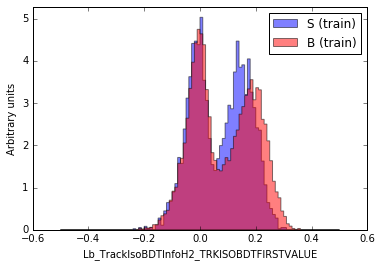

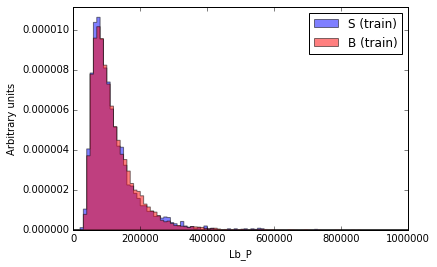

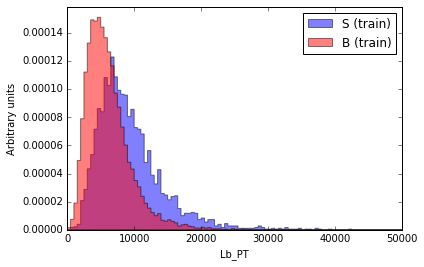

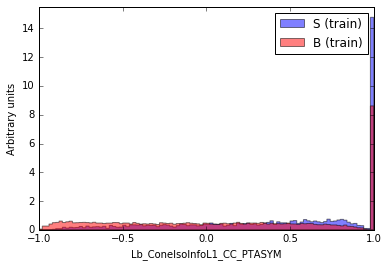

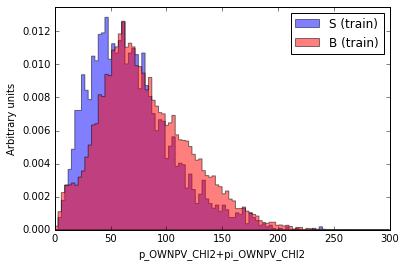

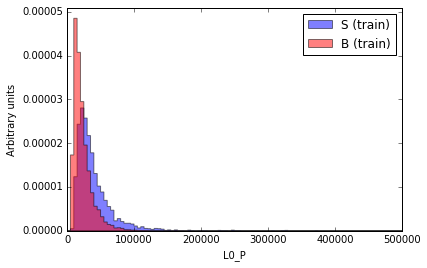

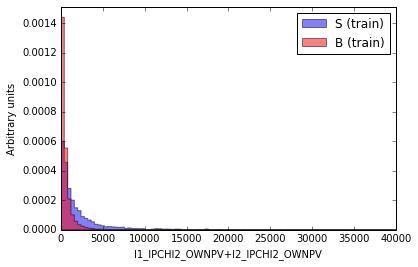

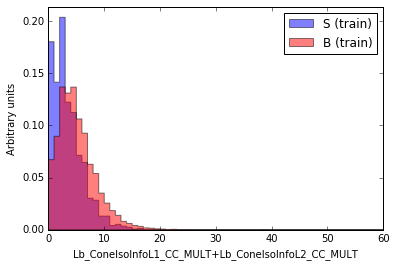

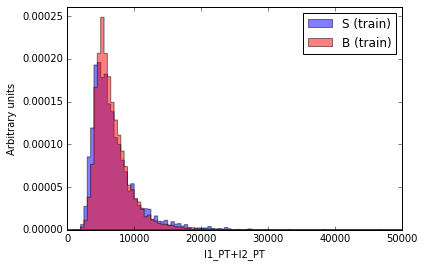

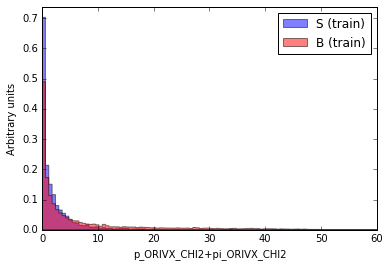

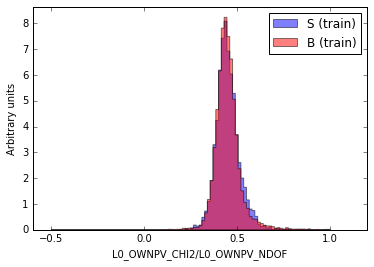

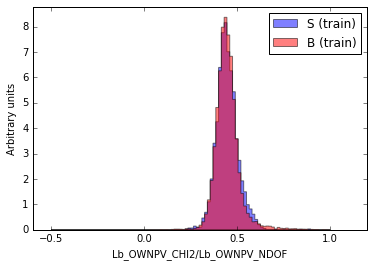

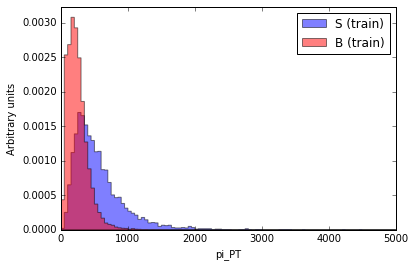

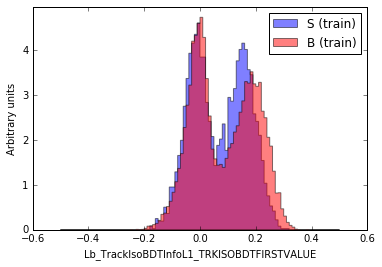

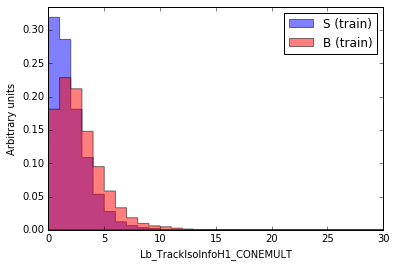

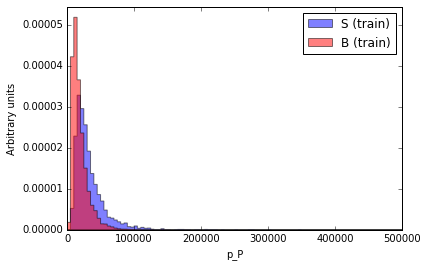

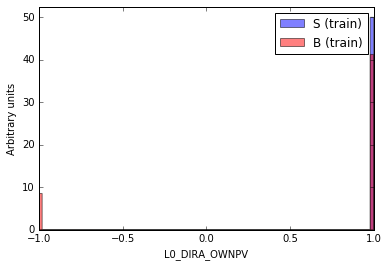

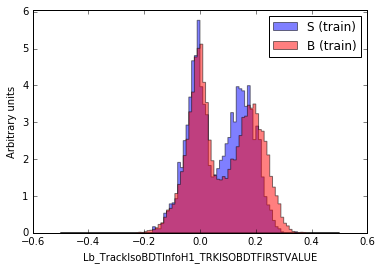

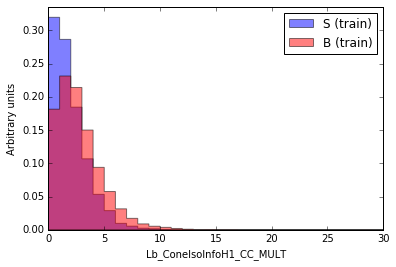

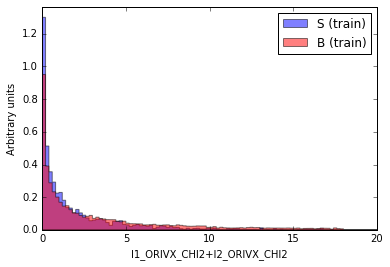

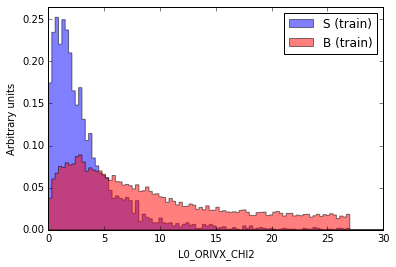

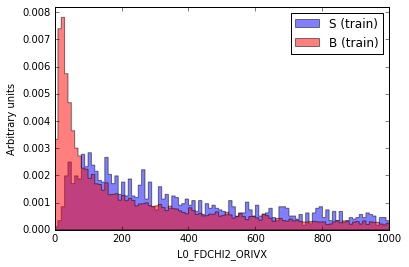

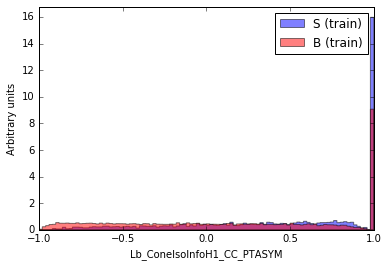

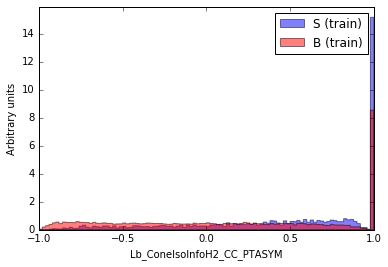

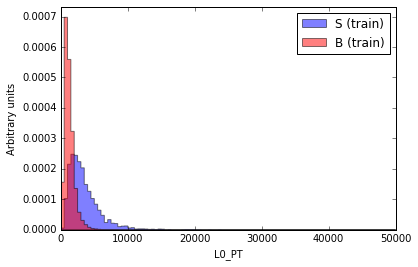

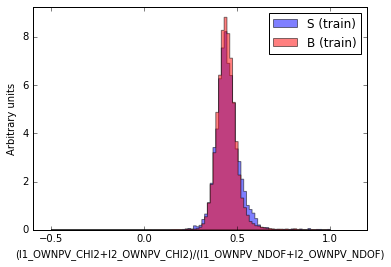

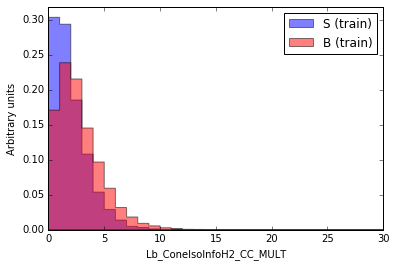

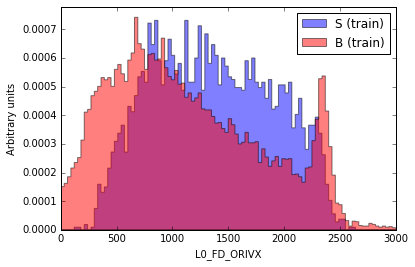

In [8]:
plots_dir = 'plots/{0}/DDvsLL/DD/'.format(decay)
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)
from tools.plot_sig_bkg import plot_sig_bkg
import imp
import sys
imp.reload (sys.modules['tools.plot_sig_bkg'])
for var in branches+additional_branches:
    plot_sig_bkg(train_data_DD_signal_with_labels, train_data_DD_background_with_labels, var, plots_dir, binning=vars_db[var]['binning'])



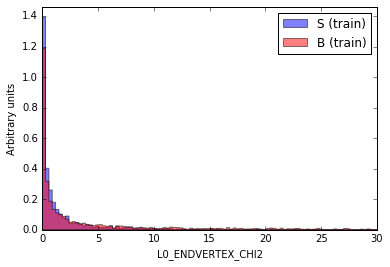

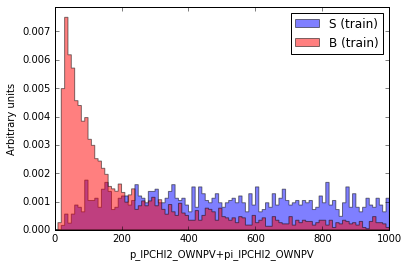

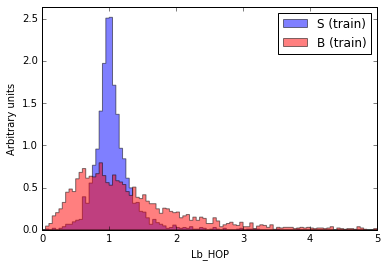

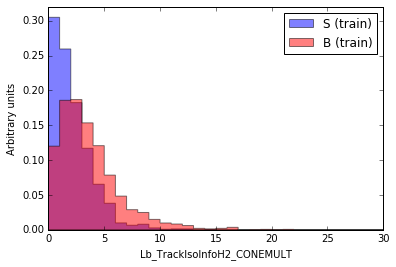

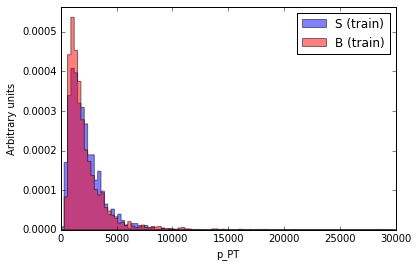

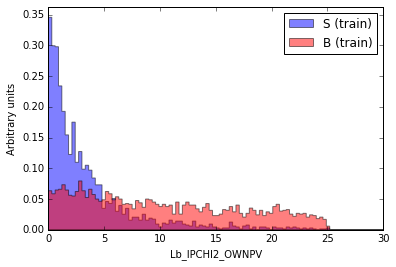

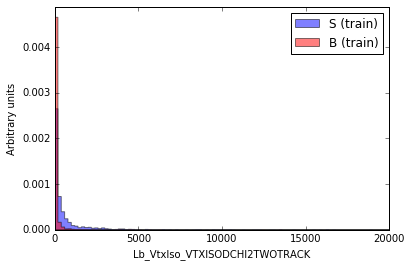

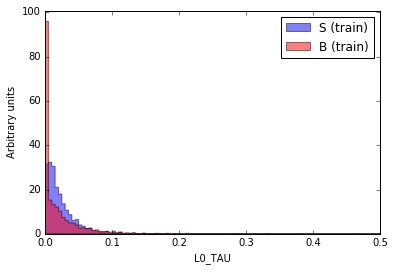

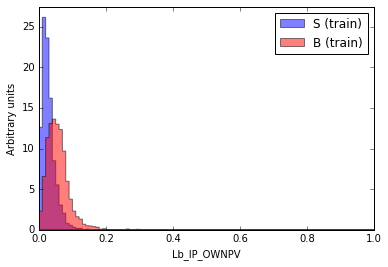

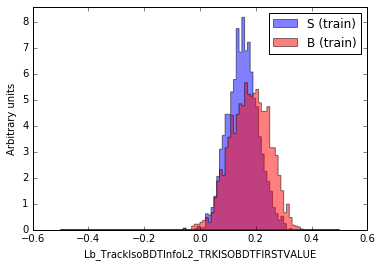

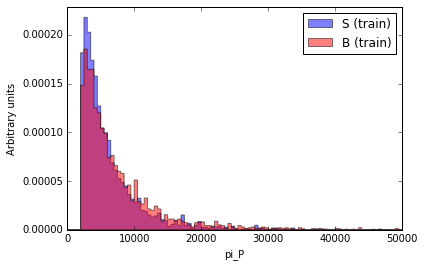

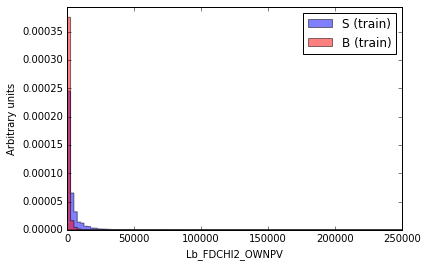

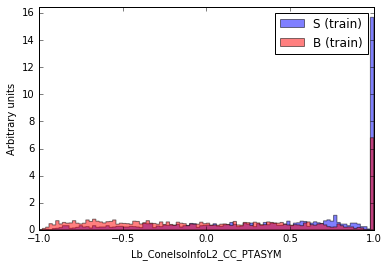

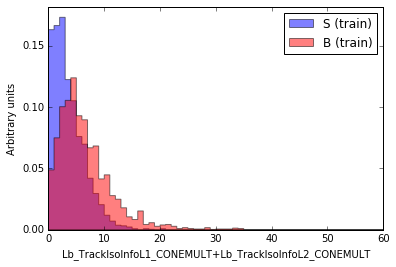

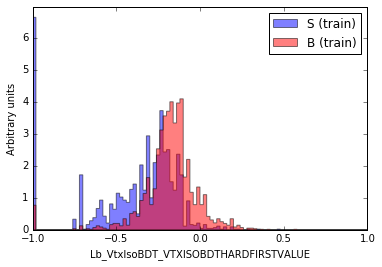

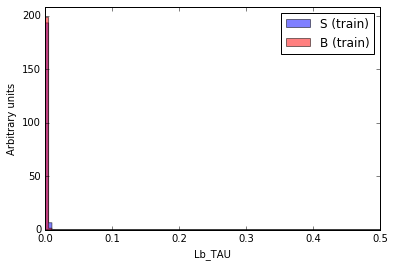

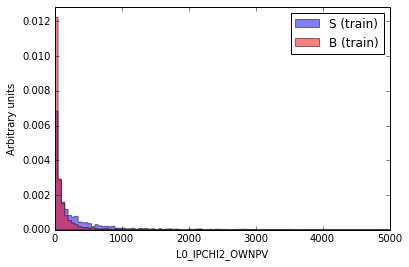

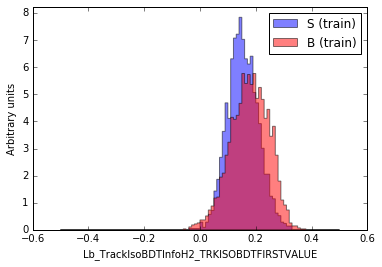

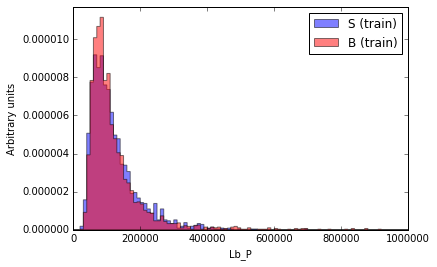

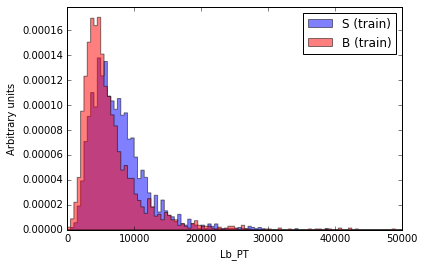

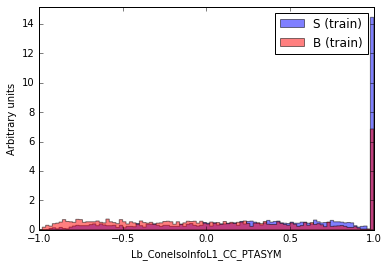

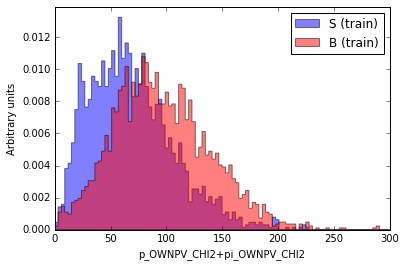

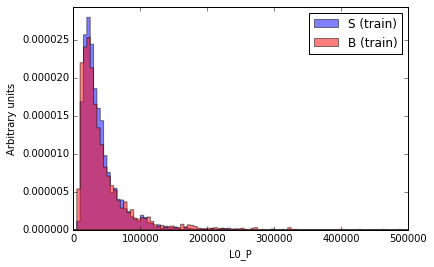

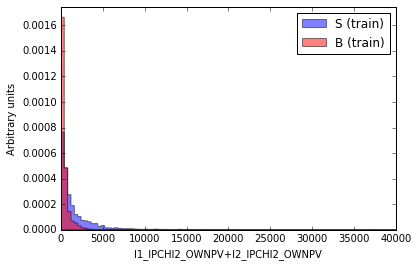

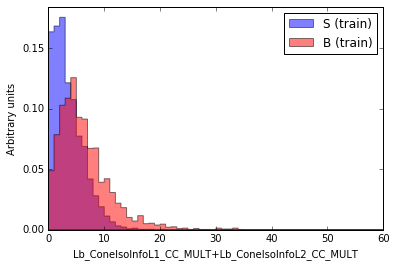

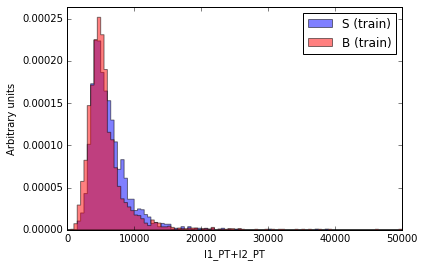

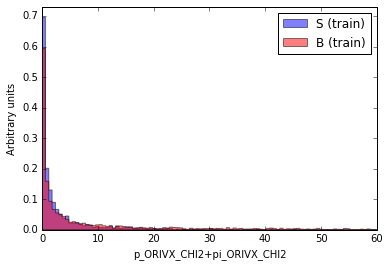

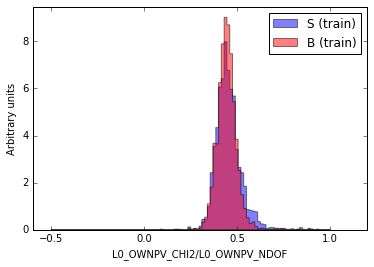

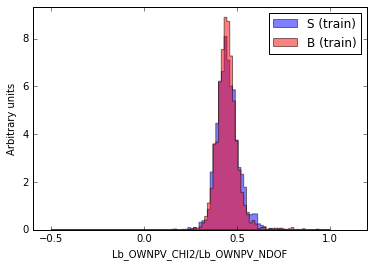

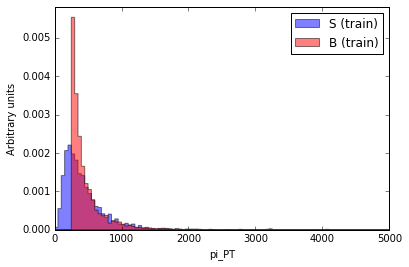

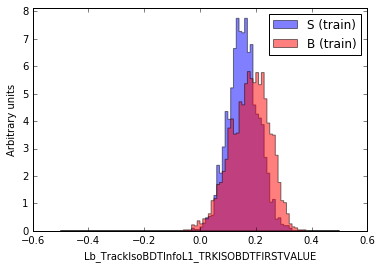

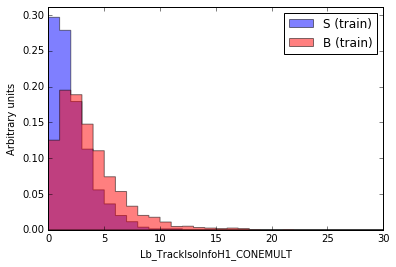

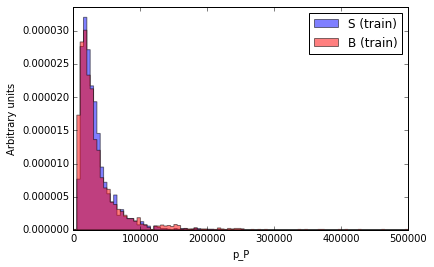

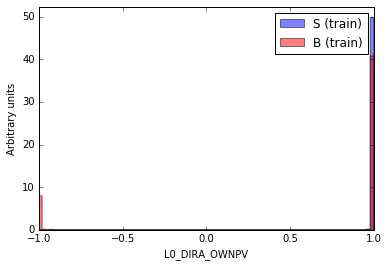

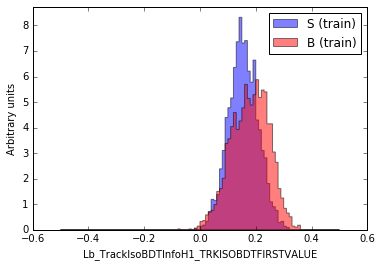

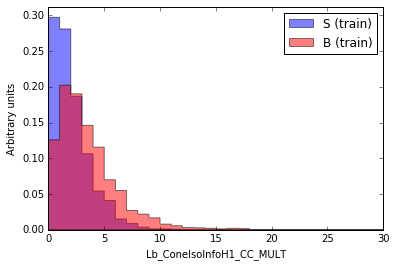

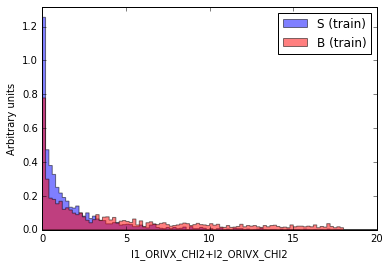

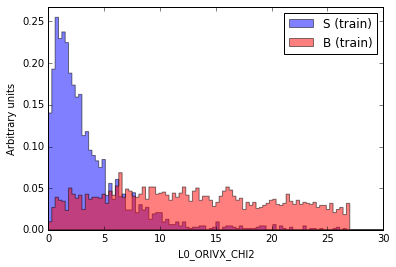

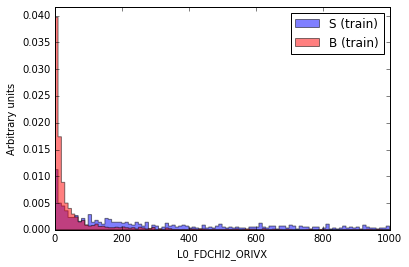

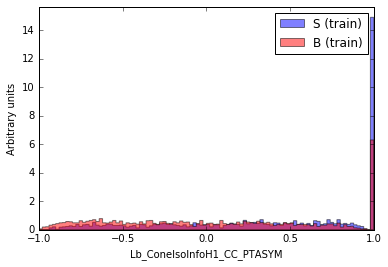

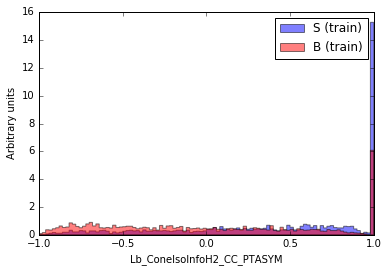

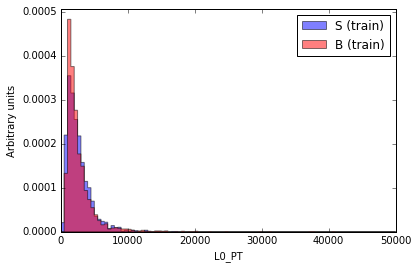

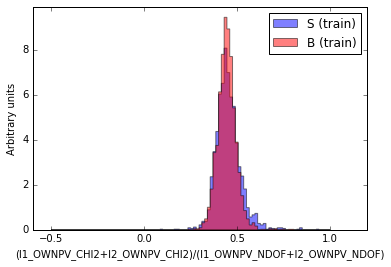

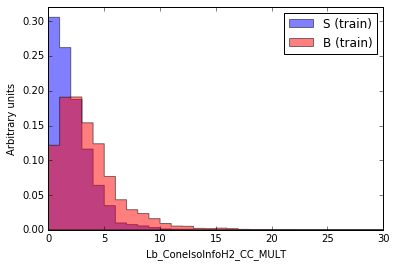

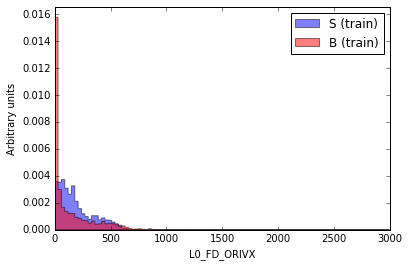

In [9]:
plots_dir = 'plots/{0}/DDvsLL/LL/'.format(decay)
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)
imp.reload (sys.modules['tools.plot_sig_bkg'])
for var in branches+additional_branches:
    plot_sig_bkg(train_data_LL_signal_with_labels, train_data_LL_background_with_labels, var, plots_dir, binning=vars_db[var]['binning'])



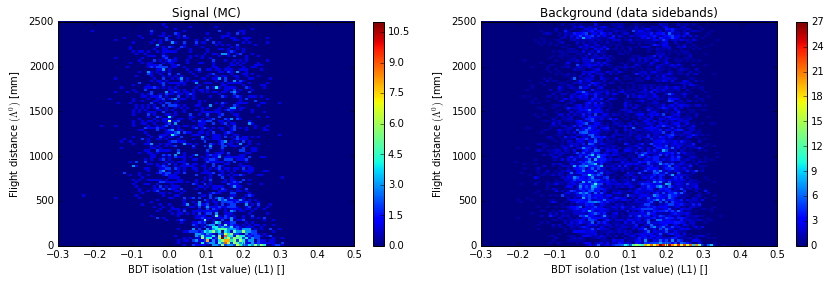

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab as p
import pickle 

plots_dir = 'plots/{0}/DDvsLL/'.format(decay)

x='Lb_TrackIsoBDTInfoL2_TRKISOBDTFIRSTVALUE'
y='L0_FD_ORIVX'

p.figure(figsize=(12,4))

#### signal
ax = plt.subplot('121')
signal_hist = plt.hist2d(train_data_signal_with_labels[x], train_data_signal_with_labels[y],
           range=((-0.3,0.5), (0,2500),),
           bins=100,)
           #norm=mpl.colors.LogNorm()) #for log z

plt.xlabel('{0} [{1}]'.format(vars_db[x]['title'], vars_db[x]['unit']).replace('#', '\\'))
plt.ylabel('{0} [{1}]'.format(vars_db[y]['title'], vars_db[y]['unit']).replace('#', '\\'))
plt.title('Signal (MC)')

plt.savefig(plots_dir+"isobdt_vs_L0FD_all.pdf")
plt.colorbar()
with open (plots_dir+'isobdt_vs_L0FD_all.py', 'wb') as myfile:
    pickle.dump(ax, myfile)
    

    
###### background
ax_bkg = plt.subplot('122')
bkg_hist = plt.hist2d(train_data_background_with_labels[x], train_data_background_with_labels[y],
           range=((-0.3,0.5), (0,2500),),
           bins=100,)
           #norm=mpl.colors.LogNorm()) #for log z

plt.xlabel('{0} [{1}]'.format(vars_db[x]['title'], vars_db[x]['unit']).replace('#', '\\'))
plt.ylabel('{0} [{1}]'.format(vars_db[y]['title'], vars_db[y]['unit']).replace('#', '\\'))
plt.title('Background (data sidebands)')

plt.savefig(plots_dir+"isobdt_vs_L0FD_all_bkg.pdf")
plt.colorbar()
with open (plots_dir+'isobdt_vs_L0FD_all_bkg.py', 'wb') as myfile:
    pickle.dump(ax_bkg, myfile)

plt.tight_layout(pad=1)
plt.show()

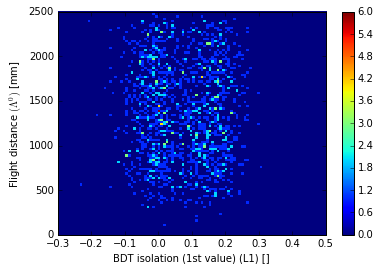

In [13]:
signal_hist_DD = plt.hist2d(train_data_DD_signal_with_labels[x], train_data_DD_signal_with_labels[y],
           range=((-0.3,0.5), (0,2500),),
           bins=100,)

plt.xlabel('{0} [{1}]'.format(vars_db[x]['title'], vars_db[x]['unit']).replace('#', '\\'))
plt.ylabel('{0} [{1}]'.format(vars_db[y]['title'], vars_db[y]['unit']).replace('#', '\\'))

plt.savefig(plots_dir+"isobdt_vs_L0FD_DD.pdf")
plt.colorbar()
plt.show()

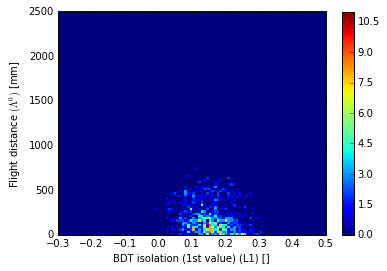

In [14]:
signal_hist_LL = plt.hist2d(train_data_LL_signal_with_labels[x], train_data_LL_signal_with_labels[y],
           range=((-0.3,0.5), (0,2500),),
           bins=100,)

plt.xlabel('{0} [{1}]'.format(vars_db[x]['title'], vars_db[x]['unit']).replace('#', '\\'))
plt.ylabel('{0} [{1}]'.format(vars_db[y]['title'], vars_db[y]['unit']).replace('#', '\\'))

plt.savefig(plots_dir+"isobdt_vs_L0TAU_LL.pdf")
plt.colorbar()
plt.show()